In [33]:
import pandas as pd
import numpy as np
import yfinance as yf
import plotly.express as px
import seaborn as sns
from datetime import *
from dateutil.relativedelta import relativedelta
from optim import *

In [34]:
cutoff_date = datetime(2023, 4, 30).date()
cutoff_date

datetime.date(2023, 4, 30)

In [35]:
pd.read_excel("portfolioTickers.xlsx")

,highCorrelationPortfolio,mixedCorrelationPortfolio,lowCorrelationPortfolio
0,AEE,PNW,ABT
1,AEP,TKO,AIG
2,CMS,AEP,AKAM
3,D,DUK,AXON
4,DTE,SO,CAG
5,DUK,CNC,CTRA
6,ED,DVA,DECK
7,ES,ED,DLTR
8,EVRG,WEC,MNST
9,LNT,AEE,MOH


Downloading historical prices

In [36]:
tickers = list(pd.read_excel("portfolioTickers.xlsx")["mixedCorrelationPortfolio"])
prices = yf.download(tickers = tickers, start = "2015-04-30", end = "2025-04-30", progress = False)["Close"].dropna()
prices

Ticker,AEE,AEP,CNC,DUK,DVA,ED,PNW,SO,TKO,WEC
Date,,,,,,,,,,
2015-04-30,30.227379,39.785175,30.995001,51.043732,81.099998,42.686886,41.696987,28.765867,11.514160,35.450623
2015-05-01,30.419348,39.897110,31.450001,51.260868,82.400002,42.763180,41.206421,29.103533,11.582796,35.797035
2015-05-04,30.707298,40.127975,32.415001,51.300358,82.339996,43.068329,41.615227,29.207428,11.720069,35.977467
2015-05-05,29.968977,39.106590,31.650000,50.175110,81.510002,42.180611,40.620499,28.746387,11.720069,34.620659
2015-05-06,29.806532,38.817009,31.775000,50.280415,81.410004,42.374802,40.470600,28.623014,11.531313,34.389717
...,...,...,...,...,...,...,...,...,...,...
2025-04-23,98.629997,107.019997,62.119999,121.419998,138.929993,112.519997,94.360001,91.129997,150.990005,108.760002
2025-04-24,98.919998,106.699997,61.580002,120.699997,139.559998,111.290001,94.480003,91.050003,155.279999,108.910004
2025-04-25,98.279999,106.739998,57.689999,119.849998,139.559998,110.449997,93.750000,90.430000,157.100006,107.730003


In [37]:
prices_train = prices.loc[:cutoff_date]
prices_test = prices.loc[cutoff_date:]

In [38]:
returns_train = prices_train.pct_change(fill_method = None).dropna()
returns_train

Ticker,AEE,AEP,CNC,DUK,DVA,ED,PNW,SO,TKO,WEC
Date,,,,,,,,,,
2015-05-01,0.006351,0.002813,0.014680,0.004254,0.016030,0.001787,-0.011765,0.011738,0.005961,0.009772
2015-05-04,0.009466,0.005787,0.030684,0.000770,-0.000728,0.007136,0.009921,0.003570,0.011851,0.005040
2015-05-05,-0.024044,-0.025453,-0.023600,-0.021935,-0.010080,-0.020612,-0.023903,-0.015785,0.000000,-0.037713
2015-05-06,-0.005420,-0.007405,0.003949,0.002099,-0.001227,0.004604,-0.003690,-0.004292,-0.016105,-0.006671
2015-05-07,0.000743,0.005458,0.005822,0.005235,0.004299,0.002291,0.005724,0.003403,0.006696,0.003148
...,...,...,...,...,...,...,...,...,...,...
2023-04-24,0.008448,0.003407,0.025307,0.005490,0.024645,0.008078,0.004095,0.006657,-0.001646,0.007109
2023-04-25,0.000441,0.001486,0.024091,0.008493,-0.009530,0.005609,0.000247,-0.001619,-0.008885,0.004706
2023-04-26,-0.019502,-0.022568,-0.038389,-0.013936,-0.011798,-0.012550,-0.024092,-0.018789,-0.020887,-0.024641


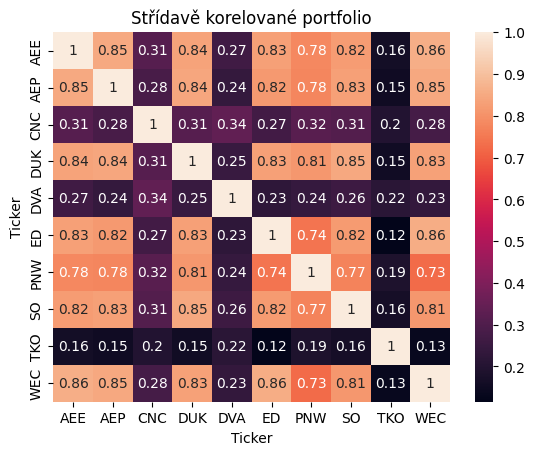

In [39]:
plt.Figure(figsize = (10, 10))
sns.heatmap(returns_train.corr(), annot = True)
plt.title("Střídavě korelované portfolio")
plt.show()

In [40]:
weightsMVOTangent = MVOTangentPortfolio(prices = prices)
weightsPlot(weightsMVOTangent, title = "MVO tangentní portfolio")

Expected annual return: 20.4%
Annual volatility: 21.9%
Sharpe Ratio: 0.93
(np.float64(0.2042542283122711), np.float64(0.2186422311360263), np.float64(0.9341938529029928))


In [41]:
weightsMVOTarget = MVOTargetReturn(prices = prices, target_return = 0.1)
weightsPlot(weightsMVOTarget, title = "MVO optimální portfolio s cílovým výnosem 10% p.a.")

Expected annual return: 11.7%
Annual volatility: 17.3%
Sharpe Ratio: 0.68
(np.float64(0.11692103632361014), np.float64(0.17318690144511228), np.float64(0.6751147768566416))


In [42]:
weightsLWCorrelationTangent = MVOTangentPortfolio(prices = prices, cov_matrix_method = "ledoit_cc")
weightsPlot(weightsLWCorrelationTangent, title = "Robustní MVO tangentní portfolio")

Expected annual return: 20.4%
Annual volatility: 21.9%
Sharpe Ratio: 0.93
(np.float64(0.20427369235993595), np.float64(0.21901469388395195), np.float64(0.9326940066778043))


In [43]:
weightsLWCorrelationTarget = MVOTargetReturn(prices = prices, target_return = 0.1, cov_matrix_method = "ledoit_cc")
weightsPlot(weightsLWCorrelationTarget, title = "Robustní MVO portfolio s cílovým výnosem 10% p.a.")

Expected annual return: 11.7%
Annual volatility: 17.4%
Sharpe Ratio: 0.67
(np.float64(0.1165734886742901), np.float64(0.17352312952790863), np.float64(0.671803747381936))


In [44]:
weightsCustomDeltaTangent = RobustLedoitWolfCustomDeltaMaxSharpe(prices = prices, custom_delta = 0.5)
weightsPlot(weightsCustomDeltaTangent, title = "Robustní tangentní portfolio s deltou 0.5")

Expected annual return: 19.4%
Annual volatility: 17.4%
Sharpe Ratio: 1.11
(np.float64(0.19367150552799528), np.float64(0.17371352703893433), np.float64(1.1148901805706113))


In [45]:
weightsCustomDeltaTarget = RobustLedoitWolfCustomDeltaTargetReturn(prices = prices, target_return = 0.1, custom_delta = 0.5)
weightsPlot(weightsCustomDeltaTarget, title = "Robustní portfolio s deltou 0.5 a cílovým výnosem 10% p.a.")

Expected annual return: 12.0%
Annual volatility: 13.8%
Sharpe Ratio: 0.88
(np.float64(0.12035573859320559), np.float64(0.1375202460606582), np.float64(0.8751855966002154))


In [46]:
weightsMinCVaR = CVaROptimizationMinCVAR(prices= prices, alpha = 0.05)
weightsPlot(weightsMinCVaR, title = "CVaR optimální portfolio")

Expected annual return: 12.3%
Conditional Value at Risk: 2.47%
(np.float64(0.12308294733528233), np.float64(0.02472647307389028))


In [47]:
anr = pd.DataFrame()

for ticker in tickers:
    rec = pd.read_excel(r"C:\Users\miros\Desktop\masters\BL_Input\AnalystRecommendation.xlsx", sheet_name = ticker)
    rec["Ticker"] = ticker
    anr = pd.concat([anr, rec])

anr["Upside"] = anr["Target Price"] / anr["Last Price"] - 1
anr

,Dates,Target Price,Last Price,Buy %,Hold %,Sell %,Price Spread,Ticker,Upside
0,2023-04-25,75.615387,80.94,0.142857,0.500000,0.357143,-5.324613,PNW,-0.065785
1,2023-05-25,75.461540,76.39,0.142857,0.500000,0.357143,-0.928460,PNW,-0.012154
2,2023-06-25,77.750000,80.81,0.142857,0.642857,0.214286,-3.060000,PNW,-0.037867
3,2023-07-25,78.750000,85.24,0.142857,0.642857,0.214286,-6.490000,PNW,-0.076138
4,2023-08-25,80.357140,79.16,0.266667,0.533333,0.200000,1.197140,PNW,0.015123
...,...,...,...,...,...,...,...,...,...
20,2024-12-25,92.125000,90.89,0.470588,0.411765,0.117647,1.235000,AEE,0.013588
21,2025-01-25,94.666664,94.12,0.529412,0.352941,0.117647,0.546664,AEE,0.005808
22,2025-02-25,100.062500,99.41,0.470588,0.411765,0.117647,0.652500,AEE,0.006564
23,2025-03-25,102.500000,97.18,0.470588,0.411765,0.117647,5.320000,AEE,0.054744


In [48]:
anr.loc[anr["Dates"] == "2023-04-25"].dropna()

,Dates,Target Price,Last Price,Buy %,Hold %,Sell %,Price Spread,Ticker,Upside
0,2023-04-25,75.615387,80.94,0.142857,0.500000,0.357143,-5.324613,PNW,-0.065785
0,2023-04-25,108.750000,99.74,0.400000,0.600000,0.000000,9.010000,DUK,0.090335
0,2023-04-25,72.187500,73.98,0.400000,0.400000,0.200000,-1.792500,SO,-0.024230
0,2023-04-25,86.500000,69.29,0.681818,0.272727,0.045455,17.210000,CNC,0.248376
0,2023-04-25,90.875000,87.30,0.111111,0.777778,0.111111,3.575000,DVA,0.040951
0,2023-04-25,90.533333,100.40,0.062500,0.500000,0.437500,-9.866667,ED,-0.098274
0,2023-04-25,102.000000,98.21,0.333333,0.666667,0.000000,3.790000,WEC,0.038591
0,2023-04-25,94.230766,90.76,0.533333,0.466667,0.000000,3.470766,AEE,0.038241


In [49]:
views = anr.loc[anr["Dates"] == "2023-04-25"][["Ticker", "Upside"]].set_index("Ticker").dropna()
views = views["Upside"].to_dict()
views

{'PNW': -0.06578469282319466,
 'DUK': 0.0903348706637257,
 'SO': -0.02422952149229529,
 'CNC': 0.24837638908933446,
 'DVA': 0.04095074455899206,
 'ED': -0.09827357744315712,
 'WEC': 0.03859077487017615,
 'AEE': 0.038241144737623634}

In [50]:
weightsBLTangent = blackLittermanAbsoluteViewsMaxSharpe(prices = prices, views = views)
weightsPlot(weightsBLTangent, title = "Black-Litterman tangentní portfolio")

Expected annual return: 11.2%
Annual volatility: 26.8%
Sharpe Ratio: 0.42
(np.float64(0.11249874454042615), np.float64(0.26790901531857886), np.float64(0.4199139935871528))


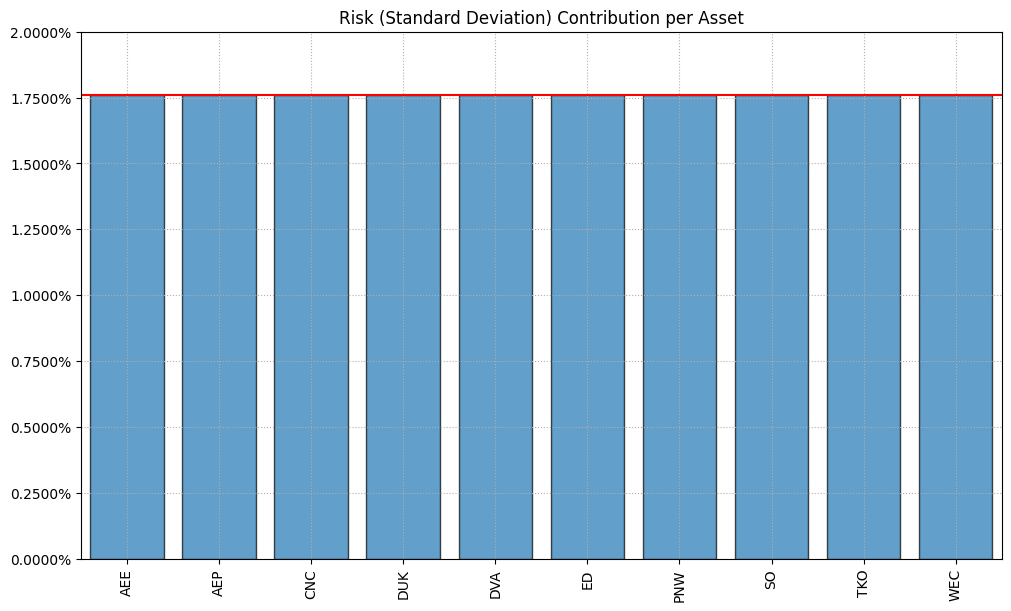

In [51]:
weightsRP_std, rpPlot = riskParityERC(prices = prices)
weightsPlot(weightsRP_std, title = "Rizikově paritní portfolio (směrodatná odchylka)")

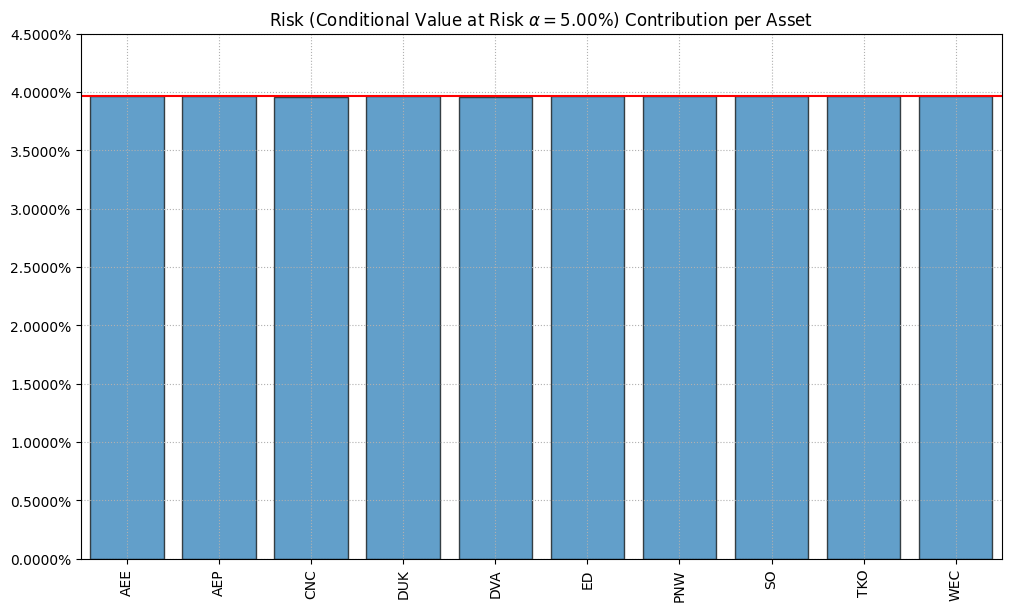

In [52]:
weightsRP_CVaR, rpPlot = riskParityERC(prices = prices, risk_measure = "CVaR")
weightsPlot(weightsRP_CVaR, title = "Rizikově paritní portfolio (CVaR)")

Hierarchical risk parity

In [53]:
in_sample = {
    'MVO': (weightsRebalancing(weightsMVOTangent, returns_df = returns_train, rebalance_freq = "ME") * returns_train).sum(axis = 1),
    'MVO (LW)': (weightsRebalancing(weightsLWCorrelationTangent, returns_df = returns_train, rebalance_freq = "ME") * returns_train).sum(axis = 1),
    'RMVO': (weightsRebalancing(weightsCustomDeltaTangent, returns_df = returns_train, rebalance_freq = "ME") * returns_train).sum(axis = 1),
    'CVaR': (weightsRebalancing(weightsMinCVaR, returns_df = returns_train, rebalance_freq = "ME") * returns_train).sum(axis = 1),
    'BL': (weightsRebalancing(weightsBLTangent, returns_df = returns_train, rebalance_freq = "ME") * returns_train).sum(axis = 1),
    'RP (std)': (weightsRebalancing(weightsRP_std, returns_df = returns_train, rebalance_freq = "ME") * returns_train).sum(axis = 1),
    'RP (CVaR)': (weightsRebalancing(weightsRP_CVaR, returns_df = returns_train, rebalance_freq = "ME") * returns_train).sum(axis = 1),
}

in_sample_returns = pd.DataFrame(in_sample)
in_sample_cumulative_returns = (1 + in_sample_returns).cumprod()
in_sample_cumulative_returns_max = in_sample_cumulative_returns.cummax()
in_sample_drawdowns = (in_sample_cumulative_returns - in_sample_cumulative_returns_max)/in_sample_cumulative_returns_max

px.line(in_sample_cumulative_returns)

In [54]:
px.line(in_sample_drawdowns, title = 'Drawdowns')

In [55]:
wdf = pd.DataFrame({
    "MVO": weightsMVOTangent,
    "MVO(LW)": weightsLWCorrelationTangent,
    "RMVO": weightsCustomDeltaTangent,
    "CVaR": weightsMinCVaR,
    "BL": weightsBLTangent,
    "RP (std)": weightsRP_std,
    "RP (CVaR)": weightsRP_CVaR
}).style.format("{:.2%}")

print(wdf.to_latex(caption = "Váhy aktiv pro vysoce korelované portfolio (vlastní zpracování)"))

\begin{table}
\caption{Váhy aktiv pro vysoce korelované portfolio (vlastní zpracování)}
\begin{tabular}{lrrrrrrr}
 & MVO & MVO(LW) & RMVO & CVaR & BL & RP (std) & RP (CVaR) \\
AEE & 21.85% & 21.85% & 14.14% & 0.00% & 0.00% & 9.40% & 9.20% \\
AEP & 0.00% & 0.00% & 8.15% & 12.89% & 0.00% & 10.07% & 9.69% \\
CNC & 0.00% & 0.00% & 0.00% & 10.24% & 69.90% & 9.65% & 10.32% \\
DUK & 0.00% & 0.00% & 2.47% & 13.47% & 21.03% & 10.03% & 9.85% \\
DVA & 0.00% & 0.00% & 0.00% & 11.88% & 1.39% & 11.02% & 11.83% \\
ED & 0.00% & 0.00% & 8.27% & 23.41% & 0.00% & 10.23% & 9.88% \\
PNW & 0.00% & 0.00% & 0.00% & 0.00% & 0.00% & 9.50% & 8.97% \\
SO & 18.80% & 18.79% & 13.39% & 9.68% & 0.00% & 9.56% & 9.70% \\
TKO & 44.71% & 44.72% & 41.16% & 13.95% & 7.68% & 10.89% & 10.99% \\
WEC & 14.64% & 14.64% & 12.42% & 4.48% & 0.00% & 9.65% & 9.58% \\
\end{tabular}
\end{table}



In [56]:
pd.DataFrame(in_sample_returns.std().sort_values().map('{:.3%}'.format)).rename(columns = {0: "std"})

,std
CVaR,1.140%
RP (CVaR),1.151%
RP (std),1.152%
RMVO,1.361%
MVO,1.421%
MVO (LW),1.421%
BL,1.756%


In [57]:
pd.DataFrame(in_sample_drawdowns.min().sort_values().map('{:.3%}'.format)).rename(columns = {0: "MDD"})

,MDD
MVO (LW),-33.769%
MVO,-33.761%
BL,-31.243%
RMVO,-30.984%
RP (std),-28.925%
RP (CVaR),-28.793%
CVaR,-28.767%


In [58]:
in_sample_cagr = (1 + in_sample_returns).prod() ** (252 / len(in_sample_returns)) - 1
pd.DataFrame(in_sample_cagr.sort_values().map('{:.2%}'.format)).rename(columns = {0: "CAGR"})

,CAGR
BL,16.96%
RP (std),17.95%
RP (CVaR),18.09%
CVaR,18.85%
RMVO,27.40%
MVO,28.78%
MVO (LW),28.79%


In [59]:
returns_test = prices_test.pct_change(fill_method=None).dropna()
returns_test

Ticker,AEE,AEP,CNC,DUK,DVA,ED,PNW,SO,TKO,WEC
Date,,,,,,,,,,
2023-05-02,-0.005802,-0.014787,-0.001895,-0.015037,-0.022680,-0.005449,-0.006082,-0.012687,-0.025353,-0.007192
2023-05-03,-0.005162,-0.004492,0.003505,-0.002766,-0.002037,-0.005377,-0.000255,0.002461,0.022891,-0.010184
2023-05-04,0.012408,0.006273,-0.021828,0.008014,-0.010776,0.004896,0.016195,0.012546,-0.024968,0.011349
2023-05-05,0.008022,0.007327,0.017406,0.012741,0.014448,0.009846,0.005396,0.009293,0.013467,0.006922
2023-05-08,-0.014701,0.000326,-0.001608,-0.004630,0.008364,-0.004825,-0.003744,-0.004937,-0.004866,-0.010207
...,...,...,...,...,...,...,...,...,...,...
2025-04-23,-0.005245,-0.010448,0.031380,-0.009059,0.029340,-0.006884,-0.006841,-0.007947,0.019307,-0.003390
2025-04-24,0.002940,-0.002990,-0.008693,-0.005930,0.004535,-0.010931,0.001272,-0.000878,0.028412,0.001379
2025-04-25,-0.006470,0.000375,-0.063170,-0.007042,0.000000,-0.007548,-0.007727,-0.006809,0.011721,-0.010835


In [60]:
out_of_sample = {
    'MVO': (weightsRebalancing(weightsMVOTangent, returns_df = returns_test, rebalance_freq = "ME") * returns_test).sum(axis = 1),
    'MVO (LW)': (weightsRebalancing(weightsLWCorrelationTangent, returns_df = returns_test, rebalance_freq = "ME") * returns_test).sum(axis = 1),
    'RMVO': (weightsRebalancing(weightsCustomDeltaTangent, returns_df = returns_test, rebalance_freq = "ME") * returns_test).sum(axis = 1),
    'CVaR': (weightsRebalancing(weightsMinCVaR, returns_df = returns_test, rebalance_freq = "ME") * returns_test).sum(axis = 1),
    'BL': (weightsRebalancing(weightsBLTangent, returns_df = returns_test, rebalance_freq = "ME") * returns_test).sum(axis = 1),
    'RP (std)': (weightsRebalancing(weightsRP_std, returns_df = returns_test, rebalance_freq = "ME") * returns_test).sum(axis = 1),
    'RP (CVaR)': (weightsRebalancing(weightsRP_CVaR, returns_df = returns_test, rebalance_freq = "ME") * returns_test).sum(axis = 1),
}

out_of_sample_returns = pd.DataFrame(out_of_sample)
out_of_sample_cumulative_returns = (1 + out_of_sample_returns).cumprod()
out_of_sample_cumulative_returns_max = out_of_sample_cumulative_returns.cummax()
out_of_sample_drawdowns = (out_of_sample_cumulative_returns - out_of_sample_cumulative_returns_max)/out_of_sample_cumulative_returns_max

px.line(out_of_sample_cumulative_returns)

In [61]:
pd.DataFrame(out_of_sample_returns.std().sort_values(ascending=False).map('{:.3%}'.format)).rename(columns = {0: "std"})

,std
BL,1.358%
MVO (LW),1.195%
MVO,1.195%
RMVO,1.140%
RP (std),0.899%
RP (CVaR),0.897%
CVaR,0.896%


In [62]:
pd.DataFrame(out_of_sample_drawdowns.min().sort_values().map('{:.3%}'.format)).rename(columns = {0: "MDD"})

,MDD
BL,-19.723%
MVO (LW),-16.632%
MVO,-16.630%
RMVO,-15.681%
RP (std),-12.126%
RP (CVaR),-11.937%
CVaR,-11.353%


In [63]:
out_of_sample_cagr = (1 + out_of_sample_returns).prod() ** (252 / len(out_of_sample_returns)) - 1
pd.DataFrame(out_of_sample_cagr.sort_values(ascending=False).map('{:.2%}'.format)).rename(columns = {0: "CAGR"})

,CAGR
MVO (LW),23.07%
MVO,23.07%
RMVO,22.73%
CVaR,20.10%
RP (CVaR),19.34%
RP (std),19.17%
BL,4.12%


In [64]:
pd.DataFrame((out_of_sample_cagr / (out_of_sample_returns.std() * np.sqrt(252))).sort_values(ascending= False)).rename(columns = {0: "CAGR/std"})

,CAGR/std
CVaR,1.413499
RP (CVaR),1.357677
RP (std),1.342825
RMVO,1.256308
MVO,1.216694
MVO (LW),1.216621
BL,0.191043
